In [2]:
import scipy.io
import numpy as np
from scipy import optimize
mat = scipy.io.loadmat('ex4data1.mat')
X = mat['X']
y = mat['y']
del mat

mat = scipy.io.loadmat('ex4weights.mat') # Pre-trainned weight
theta1 = mat['Theta1']
theta2 = mat['Theta2']
del mat
m = X.shape[0]
t1s = theta1.shape
t2s = theta2.shape

Plot random 100 images

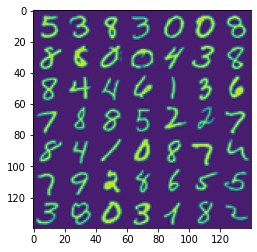

In [3]:
import matplotlib.pyplot as plt
def img_out(X_array,loc):
    return X_array[loc,:].reshape((20,-1)).T
plot_sqr = 7
img = np.zeros((plot_sqr*20,plot_sqr*20))
img_index = np.random.randint(0,high=X.shape[0],size=plot_sqr**2)
img_tmp = [X[i,:].reshape((20,-1)).T for i in img_index]
for i in range(plot_sqr):
    img[:,i*20:(i+1)*20,] =(np.array(img_tmp[i*plot_sqr:(i+1)*plot_sqr]).reshape((-1,20)))
plt.imshow(img)

Testing Forward Propagation 

In [4]:
def sigmoid(z):
    return (1/(1+np.e**(-z)))
bias = np.ones(y.flatten().shape)
a1 = np.c_[bias,X].T  # shape = (banyak gambar x param)
z2 = theta1 @ a1
a2 = np.c_[bias,sigmoid(z2.T)].T # shape = (banyak gambar x param)
z3 = theta2 @ a2
a3 = sigmoid(z3)

Change output format

In [5]:
#plt.imshow(img_out(X,0))
y_a = np.zeros((10,5000)).astype('int32')
y_temp = np.where(y==10,0,y)
for i in range(5000):
    y_a[y_temp[i],i] = 1
y_a = np.r_[y_a[1:,:], y_a[0,:].reshape(1,-1)]

Testing cost

In [6]:
J1 = np.sum(-np.multiply(y_a,np.log(a3)) - np.multiply((1-y_a),np.log(1-a3)))/5000
lamb = 1
J2 = (np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:]))) * lamb/10000
cost = J1 +J2
print(f'Cost w/o regularized is {J1:.6f} , expected value of 0.287629')
print(f'Cost w/  regularized is {cost:.6f}, expected value of 0.383770')

Cost w/o regularized is 0.287629, expected value of 0.287629
Cost w/  regularized is 0.383770, expected value of 0.383770


Create cost function and sigmoid gradient

In [7]:
def flattentheta(theta_1,theta_2):
    return np.r_[theta_1.flatten(),theta_2.flatten()]
    
def unflattentheta(thetax):
    sep = t1s[0] * t1s[1]
    th1 = thetax[:sep].reshape(t1s)
    th2 = thetax[sep:].reshape(t2s)
    return th1,th2

def forward_prop(X,th1,th2):
    bias = np.ones(m)
    a1 = np.c_[bias,X].T  # shape = (banyak gambar x param)
    z2 = th1 @ a1
    a2 = np.c_[bias,sigmoid(z2.T)].T # shape = (banyak gambar x param)
    z3 = th2 @ a2
    a3 = sigmoid(z3)
    return a1,z2,a2,z3,a3
    
thetax = flattentheta(theta1,theta2)

def J(theta,X,y,lambd=0):
    m = X.shape[0]
    th1,th2 = unflattentheta(theta)
    _,_,_,_,a3 = forward_prop(X,th1,th2)
    J1 = np.sum((-y * np.log(a3)) - ((1-y)* np.log(1-a3)))/m
    J2 = (np.sum(np.square(th1[:,1:])) + np.sum(np.square(th2[:,1:]))) * lambd/(2*m)
    return J1 + J2

def siggrad(z):
    return sigmoid(z)*(1-sigmoid(z)) 


Randomize init param

In [8]:
eps = 0.12
def randomtheta(ep):
    length = t1s[0] * t1s[1] + t2s[0] * t2s[1]
    return np.random.rand(length,)*2*ep -ep
    
theta_init = randomtheta(eps)

Testing backpropagtion

In [9]:
m = 5000
a1,z2,a2,z3,a3 = forward_prop(X,theta1,theta2)
lambd = 1
dk3 = a3-y_a
dk2 = (theta2[:,1:].T @ dk3) * siggrad(z2)
print(theta2.shape)
Delta = dk2 @ a1.T / m 
Delta2 = dk3 @ a2.T / m 
Dx = flattentheta(Delta,Delta2)
print(Delta.shape, Delta2.shape)

#Delta[:,1:] = (Delta[:,1:] + lambd * theta1[:,1:])/m
#Delta2[:,1:] = (Delta2[:,1:] + lambd * theta2[:,1:])/m

(10, 26)
(25, 401) (10, 26)


Gradient regularized neural network

In [13]:
def gradJ(theta,X,y,lambd=1):
    th1,th2 = unflattentheta(theta)
    a1,z2,a2,z3,a3 = forward_prop(X,th1,th2)
    dk3 = a3- y
    dk2 = (th2[:,1:].T @ dk3) * siggrad(z2)
    Delta = dk2 @ a1.T
    Delta2 = dk3 @ a2.T
    Delta[:,1:] = (Delta[:,1:] + lambd * th1[:,1:])/m
    Delta2[:,1:] = (Delta2[:,1:] + lambd * th2[:,1:])/m
    return flattentheta(Delta,Delta2)
a = gradJ(thetax,X,y_a)

In [12]:
def gradapprox(theta,X,y,lambdx=1,epsi=1e-4,limit=100):
    gradJx = np.zeros(limit)
    for i in range(limit):
        theta_temp = theta.copy()
        theta_temp[i] = theta_temp[i] + epsi
        J1x = J(theta_temp,X,y,lambdx)
        theta_temp[i] = theta_temp[i] - 2*epsi
        J2x = J(theta_temp,X,y,lambdx)
        theta_temp[i] = theta_temp[i] + epsi
        gradJx[i] = J1x-J2x
    return gradJx/(2*epsi)
ax = gradapprox(theta_init,X,y_a)

In [16]:
theta_init = randomtheta(0.12)
ax = gradapprox(theta_init,X,y_a,lambdx=10,epsi=1e-4,limit=10)
ay = gradJ(theta_init,X,y_a,lambd=10)
ax-ay[:10]

array([-1.16422867e+01, -1.71878202e-12,  4.06527478e-12,  1.93205899e-12,
       -1.14133719e-13,  2.61471644e-12, -7.03382123e-12,  4.17937191e-12,
       -3.43922888e-12, -3.19501015e-12])

In [15]:
#theta_init = randomtheta(0.12)

optimizer = optimize.minimize(fun=J, x0=theta_init,args=(X,y_a,0.1), method ='Newton-CG', jac=gradJ,options={'maxiter':10})
theta_init = optimizer.x
optimizer

     fun: 3.2494216455875677
     jac: array([-1.89213717e+00, -1.35096703e-06, -1.14947053e-06, ...,
        1.00841479e-03,  3.90729473e-03,  5.39321034e-03])
 message: 'Optimization terminated successfully.'
    nfev: 6
    nhev: 0
     nit: 2
    njev: 10
  status: 0
 success: True
       x: array([ 0.13694992, -0.06754835, -0.05747353, ...,  0.09488122,
        0.0752278 ,  0.0172277 ])

In [13]:
th1,th2 = unflattentheta(optimizer.x)
_,_,_,_,a3 = forward_prop(X,th1,th2)
a3[:,0]

array([0.10563227, 0.0999808 , 0.10200787, 0.10085699, 0.10262175,
       0.1069133 , 0.10302103, 0.10637237, 0.10083134, 0.10392997])